# Mini-Project 1. Feature Extraction and Transfer Learning
### Group Members: Boyu LIU(Sec 2, 5), Gengmo QI(Sec 1, 6), Xinnan DU(Sec 3), Shangzhe WU(Sec 4)

**Objective**: In this project, we intend to study features extracted using different networks (__ScatNet__ and __ResNet18__), more specifically, how effective they are in various machine learning algorithms and their distribution in high dimensional space. Besides, we would also study how well does pure deep learning method (__ResNet18__) perform when compared to traditional machine learning methods (__ScatNet__).


**Overview**: This project is composed of the following 6 sections, we demostrate experiments on __MNIST__ dataset, and provide comprehensive comparisons and analysis toward our objective: 
- Feature extraction by __ScatNet__ with known invariants
- Feature extraction by pre-trained deep neural networks __ResNet18__
- Visualize these features using classical unsupervised learning methods, including __PCA__, __MDS__, __LLE__, __LTSA__, __Hession LLE__, __Modified LLE__, __IsoMap__, __t-SNE__
- Image classifications using traditional supervised learning methods based on the features extracted, __LDA__, __Logistic Regression__, __SVM__, __Random Forests__
- Train the last layer or fine-tune the deep neural networks __ResNet18__
- Discussion and Analysis on the experiments' results

## Section 1: Feature extraction using ScatNet

__Note__: This part is implemented in MATLAB and omitted here for simplicity. The codes are available is this repository, and following experiments are conducted using the extracted features.

## Section 2: Feature extraction using ResNet18

__Note__: This part is revised based on __PyTorch__ tutorial codes on image classification. You may need to install __PyTorch__ first: http://pytorch.org/. Please also install necessary libraries needed. 

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
use_gpu = torch.cuda.is_available() ### GPU mode is recommended and could accelerate the computation effectively
print(use_gpu)

plt.ion()   # interactive mode

True


Here we use the __MNIST__ dataset provided by __PyTorch__. Due to the nature of ResNet18, the inputs will be resized as fixed size 224 by 224. __MNIST__ dataset contains 10 classes of hand-written numbers, and the original train/val split is obeyed in this project.

In [5]:
# Data preparation

root = './data'
download = True  # download MNIST dataset if not available locally

### Preprocess operations
trans = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

### MNIST dataset
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=download)
test_set = datasets.MNIST(root=root, train=False, transform=trans)
image_datasets = {'train':train_set, 'val':test_set}

### Here we use mini-batch for feature extractions (And same for fine-tuning the network)
batch_size = 10

### PyTorch dataloaders
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
dataloaders = {'train':train_loader, 'val':test_loader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].train_labels
class_names = np.unique(class_names.numpy())

In [6]:
print(class_names)

[0 1 2 3 4 5 6 7 8 9]


In [7]:
print(dataset_sizes)

{'train': 60000, 'val': 10000}


The following codes give a visual display of __MNIST__ dataset, which are one-channel hand-written numbers.

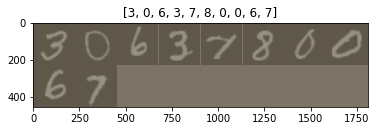

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

We would use __ResNet18__ model provided by __PyTorch__. However, as __ResNet18__ was originally trained on a different dataset, we would dispose its fully-connected layers and focus on the features extracted by its convolutional layers. Here we could observe that the numbers of features extracted is 512, and we would save it as a vector. Here we also display the structure of __ResNet18__ for your reference. 

In [6]:
model_ft = models.resnet18(pretrained=True).eval()
if use_gpu:
    model_ft=model_ft.cuda()
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In [7]:
print(model_ft)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

The features are extracted and saved for later experiments. Here we observed that __ResNet18__ running using __PyTorch__(GPU) only takes 1~2 minutes to finish, which is much faster than ScatNet's ~30 minutes (MATLAB implementation).

In [8]:
modules = list(model_ft.children())[:-1]
resnet18_feature = nn.Sequential(*modules)


features_train=[]
features_val=[]
classes_train=[]
classes_val=[]
for data in ['train', 'val']:
    for i,(images,labels) in enumerate(dataloaders[data]):
        images = torch.cat([images]*3, dim=1)
        img=Variable(images)
        if use_gpu:
            img=img.cuda()
        out=resnet18_feature.forward(img)
        out=out.view(-1,512).cpu().data.numpy()
        labels=labels.numpy()
        if data=='train':
            features_train.append(out)
            classes_train.append(labels)
        else:
            features_val.append(out)
            classes_val.append(labels)
        if i%100 == 0:
            print(i)
features_train=np.vstack(features_train)
classes_train=np.hstack(classes_train)
features_val=np.vstack(features_val)
classes_val=np.hstack(classes_val)

print('train features size:{}\tlabels size:{}'.format(features_train.shape,classes_train.shape))
print('val features size:{}\tlabels size:{}'.format(features_val.shape,classes_val.shape))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
0
100
200
300
400
500
600
700
800
900
train features size:(60000, 512)	labels size:(60000,)
val features size:(10000, 512)	labels size:(10000,)


In [11]:
### Save ResNet features
import os
if not os.path.isdir("mnist_res18_pretrained"):
    os.mkdir("mnist_res18_pretrained")

np.save("mnist_res18_pretrained/mnist_train_feature.npy", features_train)
np.save("mnist_res18_pretrained/mnist_train_label.npy", classes_train)
np.save("mnist_res18_pretrained/mnist_test_feature.npy", features_val)
np.save("mnist_res18_pretrained/mnist_test_label.npy", classes_val)

## Section 3: Feature visualization

### 3.1 Visualization of Features Using Unsupervised Learning
In this section, 8 unsupervised learning method (LLE, LTSA, Hessian LLE, Modified LLE,Isomap,MDS,TSNE,PCA) are used for dimensionality reduction. We observe that ConvNet has stronger feature extraction ability than scattering net, and among the 8 method, t-SNE works best in dimensionality reduction.

In [3]:
import random
import time
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,MDS,TSNE,LocallyLinearEmbedding,SpectralEmbedding


In [1]:
## 2D projection
def project2D(features, classes, suptitle, fig_name):
    LLE_dict=dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                        ['standard', 'ltsa', 'hessian', 'modified']))
    methods=['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','TSNE','PCA']
    # methods=['PCA']

    colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']

    fig_features=plt.figure(1,figsize=(18,9))
    fig_features.suptitle(suptitle)

    for i,method in enumerate(methods):
        print('{} starts......'.format(method))
        start_time = int(time.time())
        if method in LLE_dict.keys():
            manifold=LocallyLinearEmbedding(n_neighbors=6,method=LLE_dict[method],eigen_solver='dense')
        elif method=='MDS':
            manifold=MDS(n_init=1,max_iter=100)
        elif method=='PCA':
            exec('manifold={}(n_components=2)'.format(method))
        elif method=='TSNE':
            exec('manifold={}(n_components=2,init="pca")'.format(method))
        else:
            exec('manifold={}(n_neighbors=6)'.format(method))
        features_2D=manifold.fit_transform(features)
        np.save('features_2d_{}'.format(method),features_2D)

        ax=fig_features.add_subplot(241+i)
        for i in range(10):
            ax.scatter(features_2D[np.where(classes==i),0],features_2D[np.where(classes==i),1],s=3,c=colors[i])
        ax.legend(loc='upper right',prop={'size':11})
        ax.set_title(method)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        end_time = int(time.time())
        print('{} takes {} seconds'.format(method, str(end_time - start_time)))

    fig_features.savefig(fig_name)

###  3.2 MNIST **Scattering Net** Feature Visualization
### (a) 2d projection

In [58]:
import scipy.io

features = scipy.io.loadmat('data/mnist_scatnet/mnist_scattnet_test_all.mat')
classes = scipy.io.loadmat('data/mnist_scatnet/mnist_scattnet_test_all_label.mat')

features = features['test_features']
classes = classes['x_test_all_labels'].T[0]

LLE starts......
LLE takes 95 seconds
LTSA starts......
LTSA takes 98 seconds
Hessian LLE starts......
Hessian LLE takes 94 seconds
Modified LLE starts......
Modified LLE takes 99 seconds
Isomap starts......
Isomap takes 95 seconds
MDS starts......
MDS takes 256 seconds
TSNE starts......
TSNE takes 257 seconds
PCA starts......
PCA takes 243 seconds


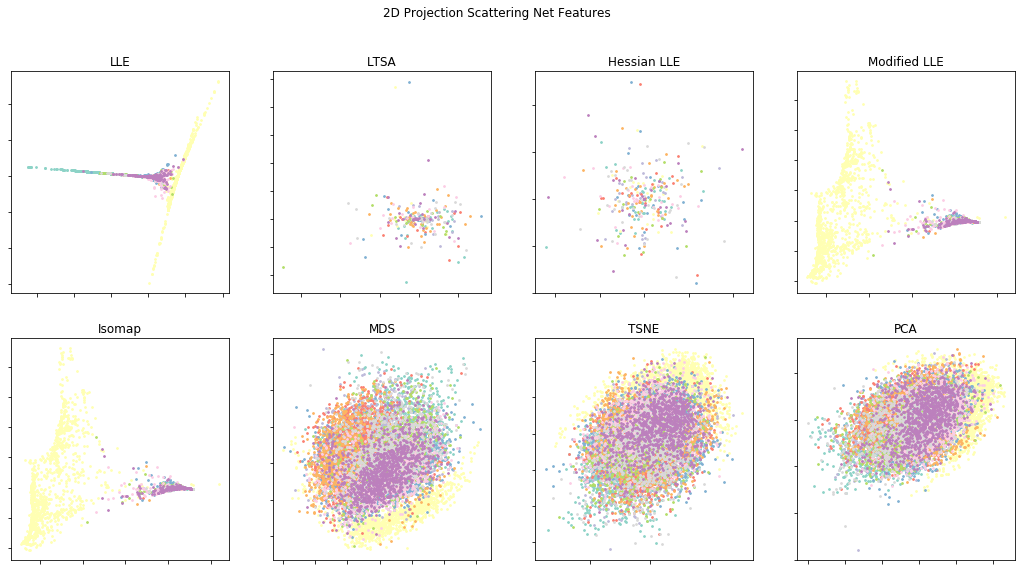

In [60]:
project2D(features, classes, '2D Projection Scattering Net Features', 'Manifold_of_scatnet.png')

### Discussion
Some observations from the above visualizations are:

(a) LLE, Modified LLE and Isomap all did a good job separating the character '1' with other characters, which is shown in yellow collor.

(b) Our t-SNE results look worse than reported in original t-SNE paper. Directly applying t-SNE to reduce the dimentionality from 512 to 2 immediately doesn't work well when comparing the above visualization with the results in the original paper(Shown below). Our guess is that, this approach suppressed some noise and distorted the interpoint distances. Whereas in the original t-SNE paper, the author started by using PCA to reduce the dimensionality of the data to 30, then use each of the dimensionality reduction techniques to convert the 30-dimensional representation to 2d.


As we can see, scattering net alone doesn't have a strong feature extraction capability. None of the the algorithms could produce clear clusters in 2d space. According to the original [t-SNE paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), t-SNE does an excellent job in revealing the natural classes of the original data without any feature extraction as shown in the image below. ![t-SNE on mnist data](https://www.mathworks.com/help/examples/stats/win64/ChangeTsneSettingsExample_01.png) 
For better visual clarity, the features are visualized in 3D space by following blocks.

### (b) 3d projection

In [61]:
### 3D projection
from mpl_toolkits.mplot3d import Axes3D
def project3D(features, classes, suptitle, fig_name):
    LLE_dict=dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                        ['standard', 'ltsa', 'hessian', 'modified']))
    methods=['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','TSNE','PCA']
    # methods=['PCA']

    colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']

    fig_features=plt.figure(1,figsize=(18,9))
    fig_features.suptitle(suptitle)

    for i,method in enumerate(methods):
        print('{} starts......'.format(method))
        start_time = int(time.time())
        if method in LLE_dict.keys():
            manifold=LocallyLinearEmbedding(n_neighbors=10,method=LLE_dict[method],eigen_solver='dense', n_components=3)
        elif method=='MDS':
            manifold=MDS(n_init=1,max_iter=100, n_components=3)
        elif method=='PCA':
            exec('manifold={}(n_components=3)'.format(method))
        elif method=='TSNE':
            exec('manifold={}(n_components=3,init="pca")'.format(method))
        else:
            exec('manifold={}(n_neighbors=6,n_components=3)'.format(method))
        features_3D=manifold.fit_transform(features)
        np.save('features_3d_{}'.format(method),features_3D)

        ax=fig_features.add_subplot(241+i, projection='3d')
        for i in range(10):
            ax.scatter(features_3D[np.where(classes==i),0],features_3D[np.where(classes==i),1],features_3D[np.where(classes==i),2],s=3,c=colors[i])
        ax.set_title(method, loc='left')
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        end_time = int(time.time())
        print('{} takes {} seconds'.format(method, str(end_time - start_time)))

    fig_features.savefig(fig_name)

LLE starts......
LLE takes 95 seconds
LTSA starts......
LTSA takes 107 seconds
Hessian LLE starts......
Hessian LLE takes 101 seconds
Modified LLE starts......
Modified LLE takes 95 seconds
Isomap starts......
Isomap takes 95 seconds
MDS starts......
MDS takes 271 seconds
TSNE starts......
TSNE takes 252 seconds
PCA starts......
PCA takes 256 seconds


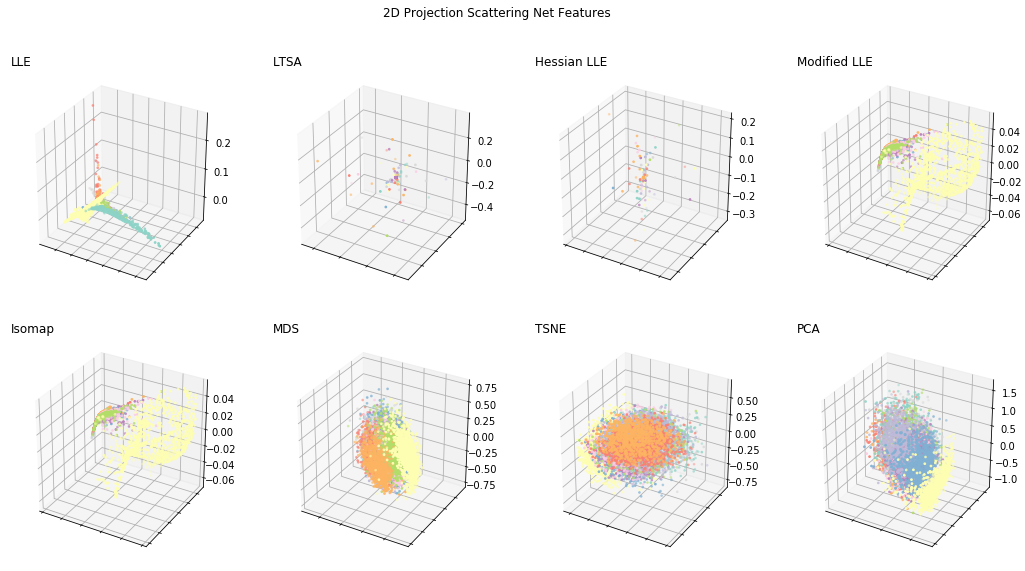

In [62]:
project3D(features, classes, '3D Projection Scattering Net Features', '3d_Scattering_Net.png')

### Discussion
Generally, 3D projection results are better than 2D projection results. Visually, t-SNE and PCA have better result. 
Modified LLE and Isomap seems good at seperating `1`s. LLE seems to be good at seperating some numbers from others. The clustering results in MDS, t-SNE and PCA look not bad, though the seperations are not necessarily perfect. 

The following illustrates t-SNE and PCA results rotated by different angles. 

### (b) 1. Rotating t-SNE results

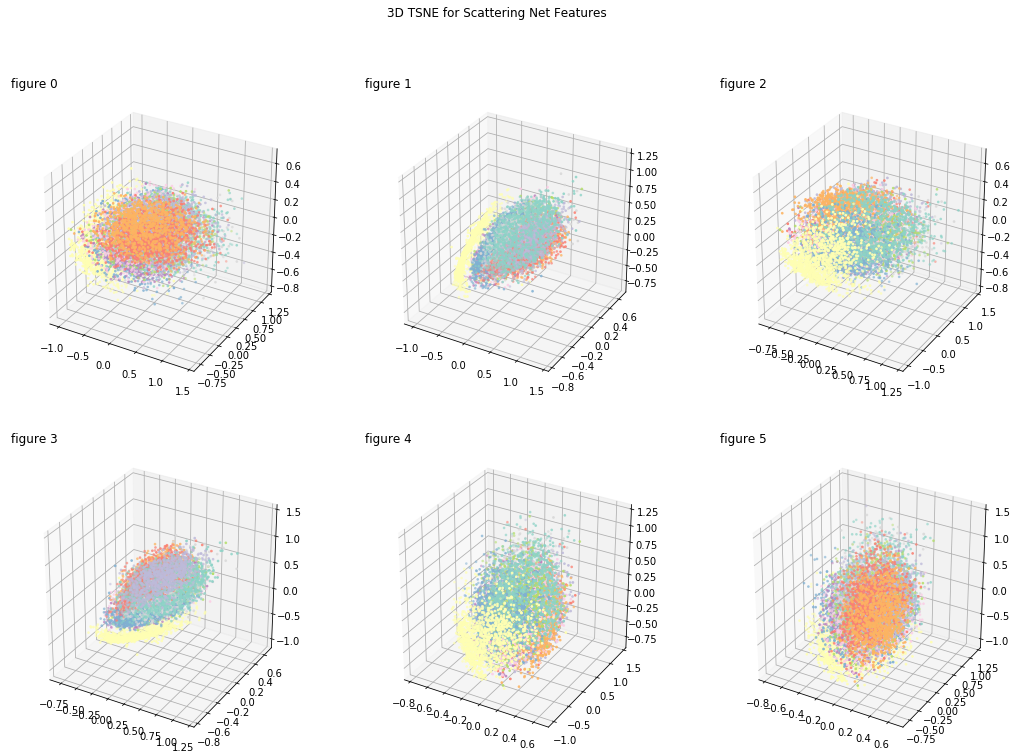

In [67]:
import itertools
manifold=TSNE(n_components=3,init="pca")
fig_3d_TSNE = plt.figure(1, figsize=(18,12))
features_3D = np.load('features_3d_TSNE.npy')
fig_3d_TSNE.suptitle('3D TSNE for Scattering Net Features')
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']

axis_permutations = list(itertools.permutations([0, 1, 2]))

for j in range(len(axis_permutations)):
    ax = fig_3d_TSNE.add_subplot(231+j, projection='3d')
    ax.set_title('figure {}'.format(str(j)), loc='left')
    curr_sequence = axis_permutations[j]
    for i in range(10):
        ax.scatter(features_3D[np.where(classes==i),curr_sequence[0]],features_3D[np.where(classes==i),curr_sequence[1]],features_3D[np.where(classes==i),curr_sequence[2]],s=3,c=colors[i])
fig_3d_TSNE.savefig('3d_TSNE_Scatter_Net.png')

### (b) 2. Rotating PCA results

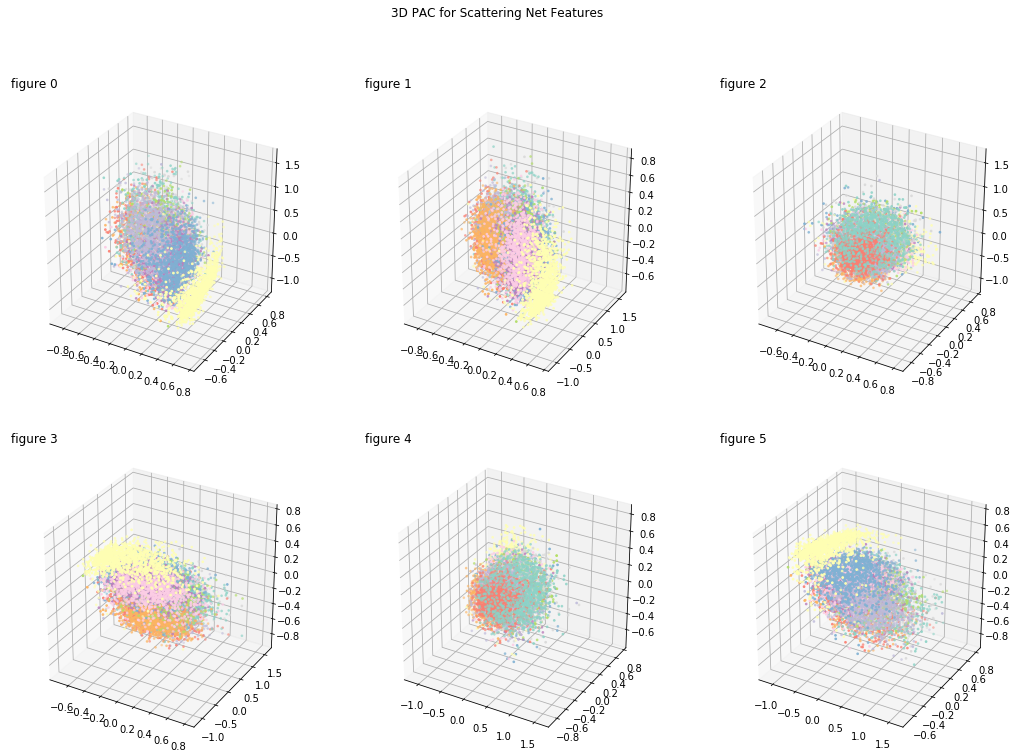

In [68]:
import itertools
manifold=TSNE(n_components=3,init="pca")
fig_3d_TSNE = plt.figure(1, figsize=(18,12))
features_3D = np.load('features_3d_PCA.npy')
fig_3d_TSNE.suptitle('3D PAC for Scattering Net Features')
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']

axis_permutations = list(itertools.permutations([0, 1, 2]))

for j in range(len(axis_permutations)):
    ax = fig_3d_TSNE.add_subplot(231+j, projection='3d')
    ax.set_title('figure {}'.format(str(j)), loc='left')
    curr_sequence = axis_permutations[j]
    for i in range(10):
        ax.scatter(features_3D[np.where(classes==i),curr_sequence[0]],features_3D[np.where(classes==i),curr_sequence[1]],features_3D[np.where(classes==i),curr_sequence[2]],s=3,c=colors[i])
fig_3d_TSNE.savefig('3d_PAC_Scatter_Net.png')

From the 3d projection above, PCA and t-SNE both demonstrated certain level of clsutering effect. However, points from different clusters are not seperated completely.

### 3.3 MNIST Resnet 18 Feature Visualization
### (a) 2d projection

In [2]:
features = np.load('data/mnist_res18_pretrained/mnist_test_feature.npy')
classes = np.load('data/mnist_res18_pretrained/mnist_test_label.npy')

LLE starts......
LLE takes 166 seconds
LTSA starts......
LTSA takes 187 seconds
Hessian LLE starts......
Hessian LLE takes 192 seconds
Modified LLE starts......
Modified LLE takes 176 seconds
Isomap starts......
Isomap takes 152 seconds
MDS starts......
MDS takes 237 seconds
TSNE starts......
TSNE takes 267 seconds
PCA starts......
PCA takes 0 seconds


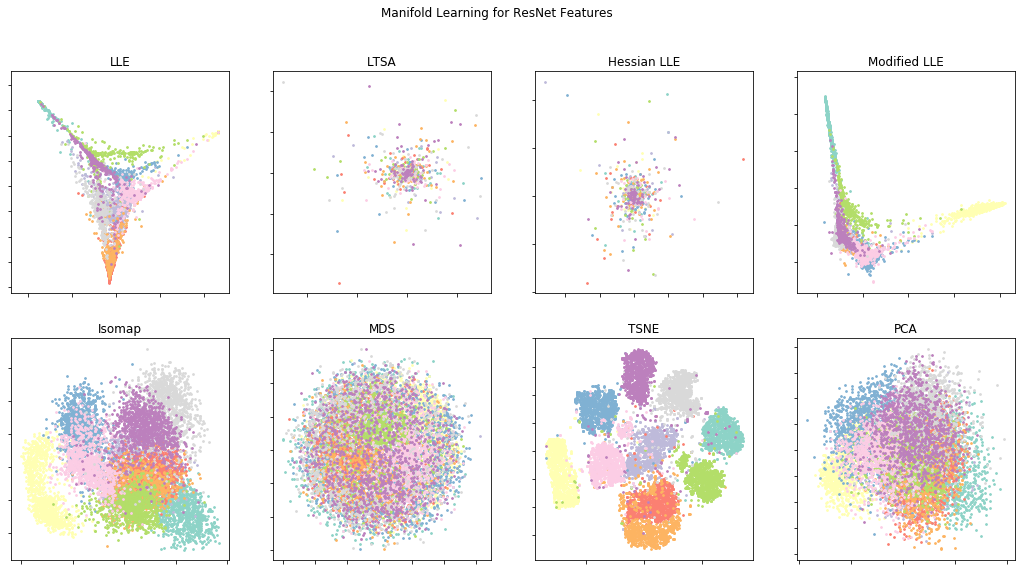

In [3]:
project2D(features, classes, 'Manifold Learning for ResNet Features', 'Manifold_of_ResNet.png')

From the results above, generally, most results of different algorithms have a better seperability than __ScatNet__ features. This indicates that the features from __ResNet18__ cluster regarding to diffrent classes, and will provide a better classification result than __ScatNet__ using machine learning methods (verified by Section 4). Among these 8 methods, t-SNE performs best on this task, which makes the clusters esay to observe and the 2d projection is nearly linearly seperable. Lets try t-SNE in 3D space.
### (b) 3d projection with t-SNE

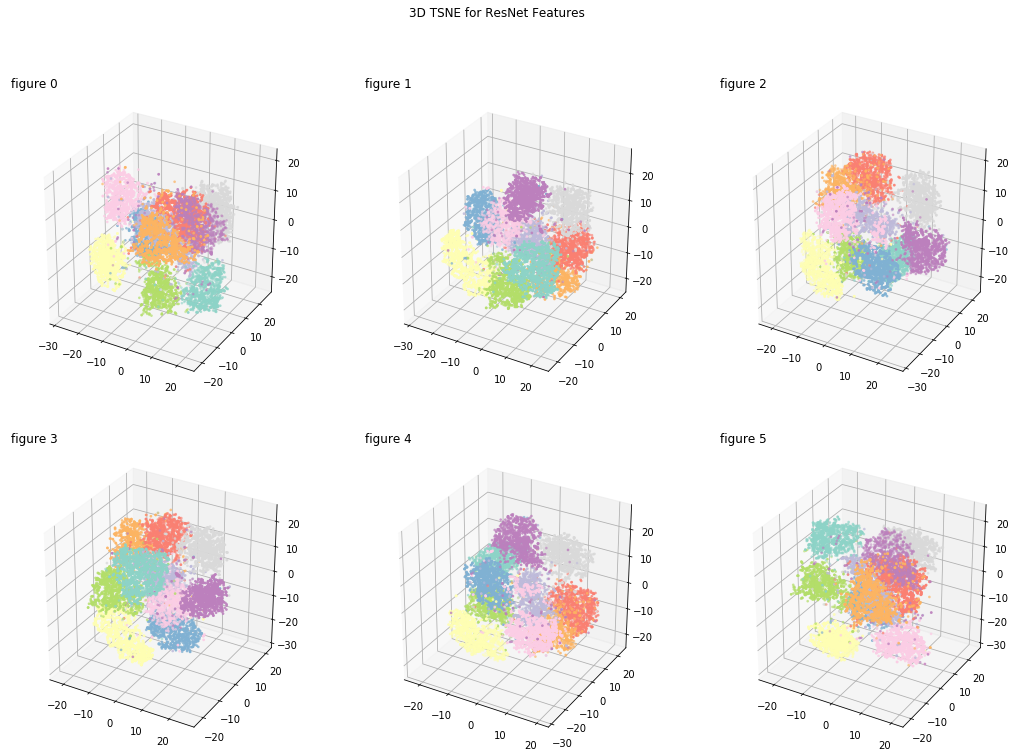

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import itertools
manifold=TSNE(n_components=3,init="pca")
features_3D=manifold.fit_transform(features_test)
np.save('features_3d_TSNE',features_3D)
fig_3d_TSNE = plt.figure(1, figsize=(18,12))
# features_3D = np.load('data/features_3d_TSNE.npy')
fig_3d_TSNE.suptitle('3D TSNE for ResNet Features')

axis_permutations = list(itertools.permutations([0, 1, 2]))

for j in range(len(axis_permutations)):
    ax = fig_3d_TSNE.add_subplot(231+j, projection='3d')
    ax.set_title('figure {}'.format(str(j)), loc='left')
    curr_sequence = axis_permutations[j]
    for i in range(10):
        ax.scatter(features_3D[np.where(classes==i),curr_sequence[0]],features_3D[np.where(classes==i),curr_sequence[1]],features_3D[np.where(classes==i),curr_sequence[2]],s=3,c=colors[i])
fig_3d_TSNE.savefig('3d_TSNE_ResNet.png')

When we compare the 3d t-SNE visualization for **ResNet** (immediately above) and the 3d t-SNE for **ScatNet**, we can see a huge performance boost for **ResNet**. Although 3d t-SNE did demonstrate clustering in **ScatNet**, the clusters did not have enough distance between each other. Whereas we can see clear clusering effect and visible distance between the clusters.

## Section 4: Classification using traditional machine learning methods

### 4.1 ScatNet features

**Note**: detailed implementations of the following functions are packaged in `model.py` and `utils.py`

In [12]:
# load features
import numpy as np

mnist_train_feature = np.load('mnist_scatnet/mnist_train_feature.npy')
mnist_train_label = np.load('mnist_scatnet/mnist_train_label.npy')
mnist_test_feature = np.load('mnist_scatnet/mnist_test_feature.npy')
mnist_test_label = np.load('mnist_scatnet/mnist_test_label.npy')

In [4]:
# fit and test models
from model import Params, Model
import time
import pandas as pd

methods = ['LDA', 'LGR', 'SVM', 'RFC']
results = pd.DataFrame(index=methods, columns=['Average Fitting Time', 'Train Accuracy', 'Average Test Time', 'Test Accuracy'])
for method in methods:
    model = Model(method)
    
    st = time.time()
    score_train = model.train(mnist_train_feature, mnist_train_label)
    ft = time.time()-st
    
    st = time.time()
    score_test = model.predict(mnist_test_feature, mnist_test_label)
    tt = time.time()-st
    results.loc[method] = [ft/len(mnist_train_feature), score_train, tt/len(mnist_test_feature), score_test]

Initializing LDA model...
Fitting the LDA model...
Finished fitting!
Predicting using LDA model...
Finished prediction!
Initializing LGR model...
Fitting the LGR model...
Finished fitting!
Predicting using LGR model...
Finished prediction!
Initializing SVM model...
Fitting the SVM model...
Finished fitting!
Predicting using SVM model...
Finished prediction!
Initializing RFC model...
Fitting the RFC model...
Finished fitting!
Predicting using RFC model...
Finished prediction!


In [5]:
results

,Average Fitting Time,Train Accuracy,Average Test Time,Test Accuracy
LDA,3.67757e-05,0.9583,1.10083e-06,0.958
LGR,0.000686586,0.918967,1.00079e-06,0.9239
SVM,0.0495049,0.727,0.0201156,0.7451
RFC,0.000264731,0.998517,7.40516e-06,0.9071


### 4.2 ResNet features

In [15]:
# load features
import numpy as np

mnist_train_feature = np.load('mnist_res18_pretrained/mnist_train_feature.npy')
mnist_train_label = np.load('mnist_res18_pretrained/mnist_train_label.npy')
mnist_test_feature = np.load('mnist_res18_pretrained/mnist_test_feature.npy')
mnist_test_label = np.load('mnist_res18_pretrained/mnist_test_label.npy')

In [16]:
# fit and test models
from model import Params, Model
import time
import pandas as pd

methods = ['LDA', 'LGR', 'SVM', 'RFC']
results = pd.DataFrame(index=methods, columns=['Average Fitting Time', 'Train Accuracy', 'Average Test Time', 'Test Accuracy'])
for method in methods:
    model = Model(method)
    
    st = time.time()
    score_train = model.train(mnist_train_feature, mnist_train_label)
    ft = time.time()-st
    
    st = time.time()
    score_test = model.predict(mnist_test_feature, mnist_test_label)
    tt = time.time()-st
    results.loc[method] = [ft/len(mnist_train_feature), score_train, tt/len(mnist_test_feature), score_test]

Initializing LDA model...
Fitting the LDA model...
Finished fitting!
Predicting using LDA model...
Finished prediction!
Initializing LGR model...
Fitting the LGR model...
Finished fitting!
Predicting using LGR model...
Finished prediction!
Initializing SVM model...
Fitting the SVM model...
Finished fitting!
Predicting using SVM model...
Finished prediction!
Initializing RFC model...
Fitting the RFC model...
Finished fitting!
Predicting using RFC model...
Finished prediction!


In [17]:
results

,Average Fitting Time,Train Accuracy,Average Test Time,Test Accuracy
LDA,2.90342e-05,0.977167,1.3603e-06,0.9746
LGR,0.00161714,0.991933,1.36828e-06,0.982
SVM,0.00924093,0.98325,0.00590839,0.9799
RFC,0.000200609,0.99905,2.67529e-06,0.9137


## Section 5: ResNet'18 finetuning

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    ### Here we first see the performance of pretrained model on validation set
    print('Before fine-tuning')
    print('-' * 10)

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for index, data in enumerate(dataloaders['val']):
        # get the inputs
        inputs, labels = data
        inputs = torch.cat([inputs]*3, dim=1)

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.data[0] * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if index%1000==0:
            print(index)

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects / dataset_sizes['val']

    print('val Loss: {:.4f} Acc: {:.4f}'.format(
         epoch_loss, epoch_acc))

    print()
    
    ## Then we train the model and output per-epoch losses
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for index, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data
                inputs = torch.cat([inputs]*3, dim=1)

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if index%1000==0:
                    print(index)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs = torch.cat([inputs]*3, dim=1)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Before fine-tuning
----------
0
val Loss: 2.3689 Acc: 0.0770

Epoch 0/4
----------
0
1000
2000
3000
4000
5000
train Loss: 0.0751 Acc: 0.9795
0
val Loss: 0.0158 Acc: 0.9954

Epoch 1/4
----------
0
1000
2000
3000
4000
5000
train Loss: 0.0228 Acc: 0.9935
0
val Loss: 0.0134 Acc: 0.9956

Epoch 2/4
----------
0
1000
2000
3000
4000
5000
train Loss: 0.0146 Acc: 0.9959
0
val Loss: 0.0125 Acc: 0.9959

Epoch 3/4
----------
0
1000
2000
3000
4000
5000
train Loss: 0.0113 Acc: 0.9967
0
val Loss: 0.0175 Acc: 0.9942

Epoch 4/4
----------
0
1000
2000
3000
4000
5000
train Loss: 0.0073 Acc: 0.9980
0
val Loss: 0.0138 Acc: 0.9958

Training complete in 21m 41s
Best val Acc: 0.995900


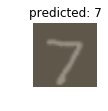

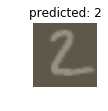

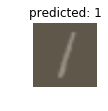

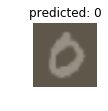

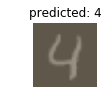

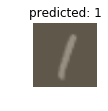

In [24]:
visualize_model(model_ft)

## Section 6: Discussion

### 6.1 ScatNet features analysis

In [5]:
# ScatNet features results
results

,Average Fitting Time,Train Accuracy,Average Test Time,Test Accuracy
LDA,3.67757e-05,0.9583,1.10083e-06,0.958
LGR,0.000686586,0.918967,1.00079e-06,0.9239
SVM,0.0495049,0.727,0.0201156,0.7451
RFC,0.000264731,0.998517,7.40516e-06,0.9071


#### (1) Train Accuracy: 
The performance among the four methods is uneven, with RFC performing the best and SVM performing poorly. This observation is quite interesting, as SVM(kernel) should be the most powerful model and should have enough model capacity for this dataset. We suspect this is due to early-stopping of the SVM fitting process. Because SVM run much slower than other algorithms, the pratical stopping criterion led to this result. Nevertheless, this also indicates the features are somewhat chaos and hard to classify. 
#### (2) Test Accuracy: 
The generalization ability of LDA, LGR and SVM is good on these features. Overfitting is present in RFC, as the max-depth is unconstrained and the algorithm will try to fit every training sample, with possibly enormous depth. This pheonomenon would be alleviated by controlling max-depth.
#### (3) Average Fitting Time: 
The two columns "fitting time" means (total time)/#(samples), and gives a metric evaluating its practicality in real use. SVM took the longest time to fit the model and test. This is pretty normal, as kernel SVM need to compute kernel, which makes it costly. 


-----

### 6.2 ResNet features analysis

In [17]:
ResNet features results

,Average Fitting Time,Train Accuracy,Average Test Time,Test Accuracy
LDA,2.90342e-05,0.977167,1.3603e-06,0.9746
LGR,0.00161714,0.991933,1.36828e-06,0.982
SVM,0.00924093,0.98325,0.00590839,0.9799
RFC,0.000200609,0.99905,2.67529e-06,0.9137


#### (1) Train Accuracy: 
The overall training performance of the 4 methods are more similar to each other compared with the large performance variance in ScatNet. And all methods acheive pretty high accuracy, and are significantly better than their ScatNet performance. This means that the data are separable in each model's capacity. And this also indicates that the features extracted by ResNet18 are forming better clusters according to classes.
#### (2) Test Accuracy: 
Overfitting still exists and similar to ScatNet features. This overfitting problem is due to intrinsic property of different machine learning algorithms. However, the high test accuracy, again, emphasizes the quality of ResNet18 features.
#### (3) Average Fitting Time: 
All four methods took roughly the same amount of time on average fitting the model compared with ScatNet. And explanations are the same as 6.1.

__Note__: It could be observed from these data that __ResNet18__ could give much better features than __ScatNet__. This is somehow amazing, as __ResNet18__ is trained on a entirely different dataset. This might indicate that the functionality of convolutional layers is to extract general high-level features, and the features are applicable to general images.

---

### 6.3 ScatNet vs. ResNet
In terms of overall test accuracy, ResNet out-performed ScatNet. Our analysis is the following: 

(1) ScatNet use predifined filters to get human-defined features, which might not be the most general and effective ones; whereas filters in ResNet were learnt during training. 

(2) ResNet is a deeper network that has more parameters, which gives it the potential to extract higher level features and more semantic information.

### 6.4 Visualization analysis
see texts around the visualizations in this notebook

### 6.5 ResNet'18 finetuning analysis
During the 5 epochs, training accuracy was increasing consistently with loss decreasing. The final result achieve quite high accuracy, which shows the power of deep neural nets. It also seems that this result surpasses traditional machine learning methods(6.2) by a large margin.

| train Loss    |train Acc      | val Loss  |val Acc|
| ------------- |-------------  | ----- |----- |
| 0.0779 | 0.9778 | 0.0156 |0.9953 |
|0.0219|0.9934 |0.0142 | 0.9957 |
|0.0158|0.9955 |0.0130 | 0.9959 |
|0.0104|0.9970 |0.0125 | 0.9957 |
|0.0068|0.9981 |0.0107 | 0.9964|


However, this comparison is __NOT fair__. As the convolutional layers are fine-tuned to fit the dataset, the features must have adapted to this dataset as well. Therefore, in the principle of fairness, we did an additional experiment. The setting is similar to Section 4.2, but use fine-tuned features. The results are as below:(the codes are omitted)

In [3]:
results

,Average Fitting Time,Train Accuracy,Average Test Time,Test Accuracy
LDA,5.34711e-05,0.999367,4.60317e-06,0.9957
LGR,0.00102568,1,4.90353e-06,0.9963
SVM,0.00135654,0.999717,0.000985597,0.9965
RFC,0.000314965,0.999983,4.60334e-06,0.9941


The results in this table is comparable with pure deep learning results. This is understandable, as ResNet18 actually only use one fully-connected layer for classification, whose model capacity would not exceed these traditional methods. 

__Note:__ This seems counter-intuitive. Neural networks surely have strong abilities of extracting features, but the FC layers at the end function similarly as traditional machine learning models, and might not necessarily be better than ML models. Commonly used multi-fully-connected-layer structure is neither efficiency nor of high model capacity. Thus, combining covolutional layers with traditional machine learning methods might be an interesting direction to explore.

## Conclusion

In this project, we have following preliminary observations:

(1) **ResNet18** (pretrained), in general, have better features than **ScatNet**, which demonstrates the power of convolutional networks which can learn from large amount of data.

(2) Various traditional machine learning methods have their respective pros and cons,as discussed in section 6.1 and 6.2, there is no universal answer as to when should we use which method, it depends on the nature and characteristics of different data sets.

(3) Fine turning deep learning networks can give signicant boost in performance, as shown in our attempt to fine ture **ResNet18**.

(4) In section 6.5, we demonstrated fine-tuning would increase the effectiveness of the extracted features, and that the traditional methods applied on these features seem to produce comparable results to the fine-tuned ResNet. 